In [1]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import dateutil
import datetime
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
data = pd.read_csv("Motor_Vehicle_Collisions_Crashes_NYPD.csv", low_memory = False)
data['CRASH DATE'] = data['CRASH DATE'].apply(dateutil.parser.parse, dayfirst=True)

In [3]:
data['year'] = pd.DatetimeIndex(data['CRASH DATE']).year
data['month'] = pd.DatetimeIndex(data['CRASH DATE']).month
data['season'] = (data['month']%12 + 3)//3
seasons = {1: '1 Winter', 2: '2 Spring', 3: '3 Summer', 4: '4 Autumn'}
data['season_name'] = data['season'].map(seasons)
data.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,year,month,season,season_name
0,2021-02-02,0:00,NaN,NaN,NaN,NaN,NaN,NEW ENGLAND THRUWAY,NaN,NaN,...,4388602,Sedan,NaN,NaN,NaN,NaN,2021,2,1,1 Winter
1,2021-01-02,0:15,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,4388510,Sedan,Sedan,NaN,NaN,NaN,2021,1,1,1 Winter
2,2021-01-02,15:30,NaN,NaN,40.697815,-73.7602,"(40.697815, -73.7602)",114 ROAD,NaN,NaN,...,4388639,Sedan,NaN,NaN,NaN,NaN,2021,1,1,1 Winter
3,2021-01-02,2:35,NaN,NaN,NaN,NaN,NaN,PROSPECT EXPRESSWAY RAMP,NaN,NaN,...,4388200,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,2021,1,1,1 Winter
4,2020-10-27,9:00,NaN,NaN,NaN,NaN,NaN,BRUCKNER EXPRESSWAY,NaN,NaN,...,4361834,commercial,Sedan,NaN,NaN,NaN,2020,10,4,4 Autumn


In [4]:
df = data
df['Casualty'] = df['NUMBER OF PERSONS INJURED']+df['NUMBER OF PERSONS KILLED']
df_casualty = df.dropna(how = 'any', subset = ['Casualty'])

In [5]:
#One-way ANOVA analysis
lm = ols('Casualty ~ season_name', data = df_casualty).fit()
table1 = sm.stats.anova_lm(lm)
print(table1)

                    df         sum_sq    mean_sq          F        PR(>F)
season_name        3.0     120.146422  40.048807  89.437046  7.232237e-58
Residual     1752473.0  784735.822012   0.447788        NaN           NaN


In [6]:
#Pairwise comparison (Tukey's HSD)
table2 = pairwise_tukeyhsd(df_casualty['Casualty'], df_casualty['season_name'])
print(table2)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj  lower   upper  reject
-------------------------------------------------------
1 Winter 2 Spring   0.0069 0.001  0.0032  0.0107   True
1 Winter 3 Summer   0.0216 0.001   0.018  0.0253   True
1 Winter 4 Autumn   0.0159 0.001  0.0123  0.0196   True
2 Spring 3 Summer   0.0147 0.001   0.011  0.0184   True
2 Spring 4 Autumn    0.009 0.001  0.0053  0.0127   True
3 Summer 4 Autumn  -0.0057 0.001 -0.0093 -0.0021   True
-------------------------------------------------------


In [7]:
df1 = df
df1['Casualty'] = np.where(df['NUMBER OF PERSONS INJURED']+df['NUMBER OF PERSONS KILLED']>0, True, False)
df1 = df1.groupby(['season_name', 'Casualty']).size().reset_index(name = 'Counts')
df1['RATIO'] = df1['Counts']/df1.groupby('season_name')['Counts'].transform('sum')
df1 = df1[df1['Casualty'] >0]

In [8]:
df2 = df
df2['PEDESTRIANS CASUALTY']= np.where(df['NUMBER OF PEDESTRIANS INJURED']+df['NUMBER OF PEDESTRIANS KILLED']>0, True, False)
df2 = df.groupby(['season_name', 'PEDESTRIANS CASUALTY']).size().reset_index(name = 'PEDESTRIANS CASUALTY Counts')
df2['PEDESTRIANS CASUALTY RATIO'] = df2['PEDESTRIANS CASUALTY Counts']/df2.groupby('season_name')['PEDESTRIANS CASUALTY Counts'].transform('sum')
df2 = df2[df2['PEDESTRIANS CASUALTY'] == True]
df2

,season_name,PEDESTRIANS CASUALTY,PEDESTRIANS CASUALTY Counts,PEDESTRIANS CASUALTY RATIO
1,1 Winter,True,23221,0.054947
3,2 Spring,True,19917,0.047804
5,3 Summer,True,20339,0.044706
7,4 Autumn,True,24023,0.052416


In [9]:
df3 = df
df3['CYCLIST CASUALTY']= np.where(df['NUMBER OF CYCLIST INJURED']+df['NUMBER OF CYCLIST INJURED']>0, True, False)
df3 = df.groupby(['season_name', 'CYCLIST CASUALTY']).size().reset_index(name = 'CYCLIST CASUALTY Counts')
df3['CYCLIST CASUALTY RATIO'] = df3['CYCLIST CASUALTY Counts']/df3.groupby('season_name')['CYCLIST CASUALTY Counts'].transform('sum')
df3 = df3[df3['CYCLIST CASUALTY'] == True]
df3

,season_name,CYCLIST CASUALTY,CYCLIST CASUALTY Counts,CYCLIST CASUALTY RATIO
1,1 Winter,True,7000,0.016564
3,2 Spring,True,8734,0.020963
5,3 Summer,True,12937,0.028436
7,4 Autumn,True,10902,0.023787


In [10]:
df4 = df
df4['MOTORIST CASUALTY']= np.where(df['NUMBER OF MOTORIST INJURED']+df['NUMBER OF MOTORIST INJURED']>0, True, False)
df4 = df.groupby(['season_name', 'MOTORIST CASUALTY']).size().reset_index(name = 'MOTORIST CASUALTY Counts')
df4['MOTORIST CASUALTY RATIO'] = df4['MOTORIST CASUALTY Counts']/df4.groupby('season_name')['MOTORIST CASUALTY Counts'].transform('sum')
df4 = df4[df4['MOTORIST CASUALTY'] == True]
df4

,season_name,MOTORIST CASUALTY,MOTORIST CASUALTY Counts,MOTORIST CASUALTY RATIO
1,1 Winter,True,52300,0.123755
3,2 Spring,True,53548,0.128524
5,3 Summer,True,60907,0.133875
7,4 Autumn,True,59242,0.129261


In [11]:
df1_2 = pd.merge(df1, df2, on ='season_name')
df3_4 = pd.merge(df3, df4, on ='season_name')
df5 = pd.merge(df1_2, df3_4, on ='season_name')

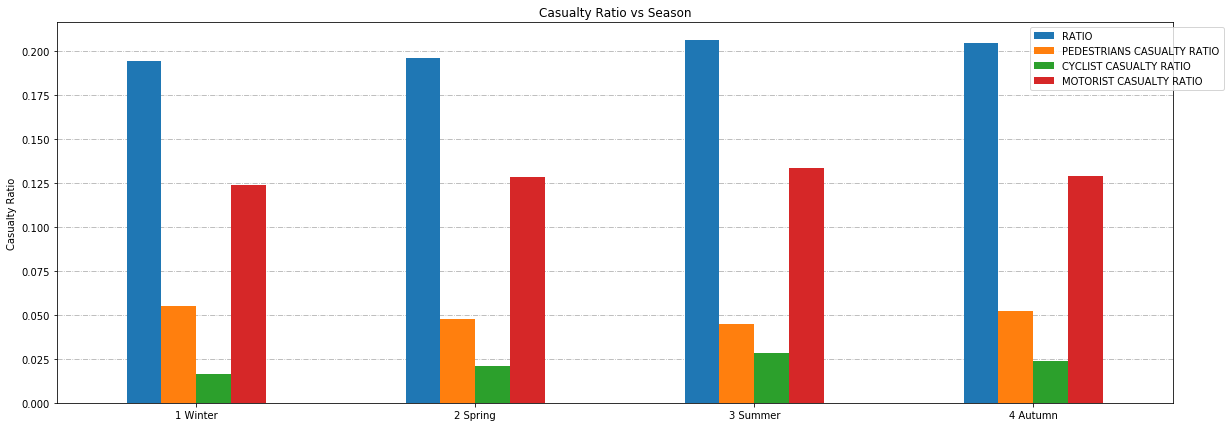

In [17]:
import matplotlib.pyplot as plt
plot=df5.plot(x='season_name', y = ['RATIO', 'PEDESTRIANS CASUALTY RATIO', 'CYCLIST CASUALTY RATIO', 'MOTORIST CASUALTY RATIO'], 
         kind ='bar', figsize=(20, 7), stacked = False, rot =0)
plt.title('Casualty Ratio vs Season')
plt.ylabel('Casualty Ratio')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel('')
plot.yaxis.grid(zorder =0, which='major', linestyle='-.')
plot.xaxis.grid(which='minor', linewidth= 0)
plot.set_axisbelow(True)
plt.show()